In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import GenerationDiscreteObs as FSC_DiscreteObs
from FSC import InferenceDiscreteObs as FSC_InferenceDiscreteObs
import ObsModels 

(array([490., 264., 128.,  50.,  32.,  17.,  11.,   3.,   2.,   3.]),
 array([1.39855729e-03, 6.82256620e+00, 1.36437338e+01, 2.04649015e+01,
        2.72860691e+01, 3.41072368e+01, 4.09284044e+01, 4.77495721e+01,
        5.45707397e+01, 6.13919073e+01, 6.82130750e+01]),
 <BarContainer object of 10 artists>)

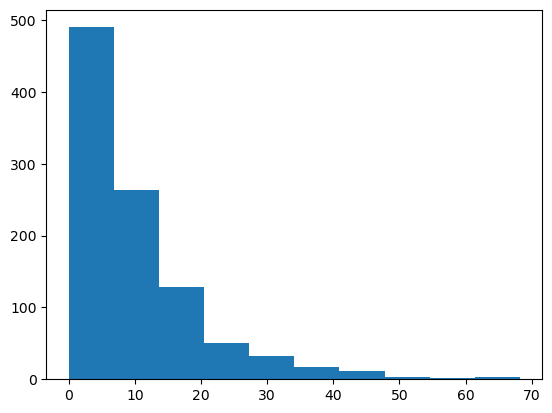

In [8]:
plt.hist(ObsModels.get_waiting_times(1000, 0.1))